In [4]:
from dfuncs import dfuncs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, Bounds
from sympy import symbols, solve, lambdify, exp

In [2]:
mpl.rcParams['font.size'] = 22
mpl.rcParams['figure.figsize'] = (12, 8)

### Hormone Equations

$$
\begin{cases}
\dfrac{ dC }{ dt } = c_{\text{max}} - (1 + qR_{B})C \\[5pt]
\dfrac{ dR_{0} }{ dt } = u(1 + vC) - k_{\text{on}}R_{0}B  + k_{\text{off}}R_{B} - R_{0} \\[5pt]
\dfrac{ dR_{B} }{ dt } = k_{\text{on}}R_{0}B  -  k_{\text{off}}R_{B}  - R_{B} \\[5pt]
\dfrac{ dM }{ dt } = \dfrac{ \alpha _{M}C }{ L } - M \\[5pt]
\end{cases}
$$
### Growth Equation

$$
\dfrac{ dL }{ dt } = \dfrac{ g_{B}R_{B}L }{ (1 + g_{A}A)(1 + g_{M}M / L) } 
$$

### Division Equation
$$
\dfrac{ d\theta   }{ dt } = d_{\text{min}} + \dfrac{ 1 }{ e^{ -d_{0}(M - d_{1})^{2} }  }
$$

In [10]:
CPD, ROT3, BES1, AUXIN, SIZE, POSITION = dfuncs().values()
BR = np.vectorize(lambda p : (CPD(p) + ROT3(p)) / 100)
STEP = 0.01
vT = np.arange(0, 15 + STEP, STEP)

In [19]:
def setup():

    # Define parameters and variables
    params = symbols('c_max, q, u, v, k_on, k_off, a_M, g_B, g_A, g_M, d_min, d_0, d_1')
    c_max, q, u, v, k_on, k_off, a_M, g_B, g_A, g_M, d_min, d_0, d_1 = params
    
    # Define the symbols representing hormone levels
    C, R0, RB, M, B, A, L = symbols('C R0 RB M B A L')

    # Write the hormone equations down as a system
    hormone_eqn = [
        c_max - (1 + q * RB) * C,
        u * (1 + v * C) - k_on * R0 * B + k_off * RB - R0,
        k_on * R0 * B - (1 + k_off) * RB,
        (a_M * C / L) - M
    ]

    # Solve hormone equations, choosing the second root to ensure positive solutions
    hormone_ss = solve(hormone_eqn, [C, R0, RB, M], dict = True)[-1]
    fC, fR0, fRB, fM = [lambdify([params, B, L], hormone_ss[h]) for h in [C, R0, RB, M]]

    # Write down the growth equation and convert it into a lambda function
    growth_eqn = (g_B * RB * L) / ((1 + g_A * A) * (1 + g_M * M / L))
    fdL = lambdify([params, RB, A, M, L], growth_eqn)

    # Define the division equation and convert it into a lambda function
    division_eqn = d_min + 1 / (exp(-d_0 * (M - d_1) ** 2))
    fdT = lambdify([params, M], growth_eqn)

    # Return the list of lambda functions
    return [fC, fR0, fRB, fM, fdL, fdT]

In [21]:
simulation = setup()

In [7]:
# Returns the midpoints of a vector of cell lengths
def get_midpoints(Li):
    ends = np.cumsum(Li)
    starts = np.append(0, ends)[:-1]
    return (starts + ends) / 2

# Checks the error on a given vector of lengths, also check average division time
def check_error(Li, Dt, Dc):
    Mi = get_midpoints(Li)
    midpoint_nrmse = sum(np.square(SIZE(Mi) - Li) / np.square(SIZE(Mi)))
    avg_division = Dt / Dc if Dc != 0 else 0
    division_nrmse = (12 - avg_division) ** 2
    return midpoint_nrmse + division_nrmse

# Runs a complete simulation for a given set of parameters
def simulate_cells(params):

    # Unpack the parameters, get growth and division functions
    *hormone_params, g_B, g_A, d_min, d_M, d_0, d_1 = params
    growth = np.vectorize(get_growth(g_B, g_A))
    division = np.vectorize(get_division(d_min, d_M, d_0, d_1))

    # Initialize the following vectors:
    L0, D0 = config["initial_lengths"], config["initial_division"]
    L, Li = [L0], L0                 # Cell lengths
    D, Di = [D0], D0                 # Division factors
    T, Dt, Dc = [0] * len(L0), 0, 0  # Time of last division

    # Perform partial function application from setup() with the given parameters
    funcs = [lambda B : f(hormone_params, B) for f in SS]
    
    # Run through the simulation, inducing cell growth, then division, then dividing cells if necessary
    for time in ts:
        mid = get_midpoints(Li)
        B = BR(mid)
        A = AUXIN(mid)
        C, R0, RB, M = [f(B) for f in funcs]
        
        # Perform cell growth
        Li = Li + (growth(RB, A) * config["step"])
        
        # Perform cell division
        Di = Di + (division(M, Li) * config["step"])

        # Divide cells if necessary
        Li, Di, T, Dt, Dc = divide_cells(Li, Di, T, Dt, Dc, time)
        
        # Update L and D
        L.append(Li)
        D.append(Di)

    error = check_error(L[-1], Dt, Dc)
    return (L, D), error

def cost(params):
    return simulate_cells(params)[-1]

In [8]:
%%time
res = minimize(
    cost, 
    config["initial_params"], 
    method='trust-constr', 
    bounds=Bounds(0.01, 100), 
    options={"maxiter": 100}
)

KeyboardInterrupt: 

In [12]:
%%time
(L, D), error = simulate_cells(config["initial_params"])
# print(error, res.x)

CPU times: user 121 ms, sys: 10.2 ms, total: 131 ms
Wall time: 124 ms


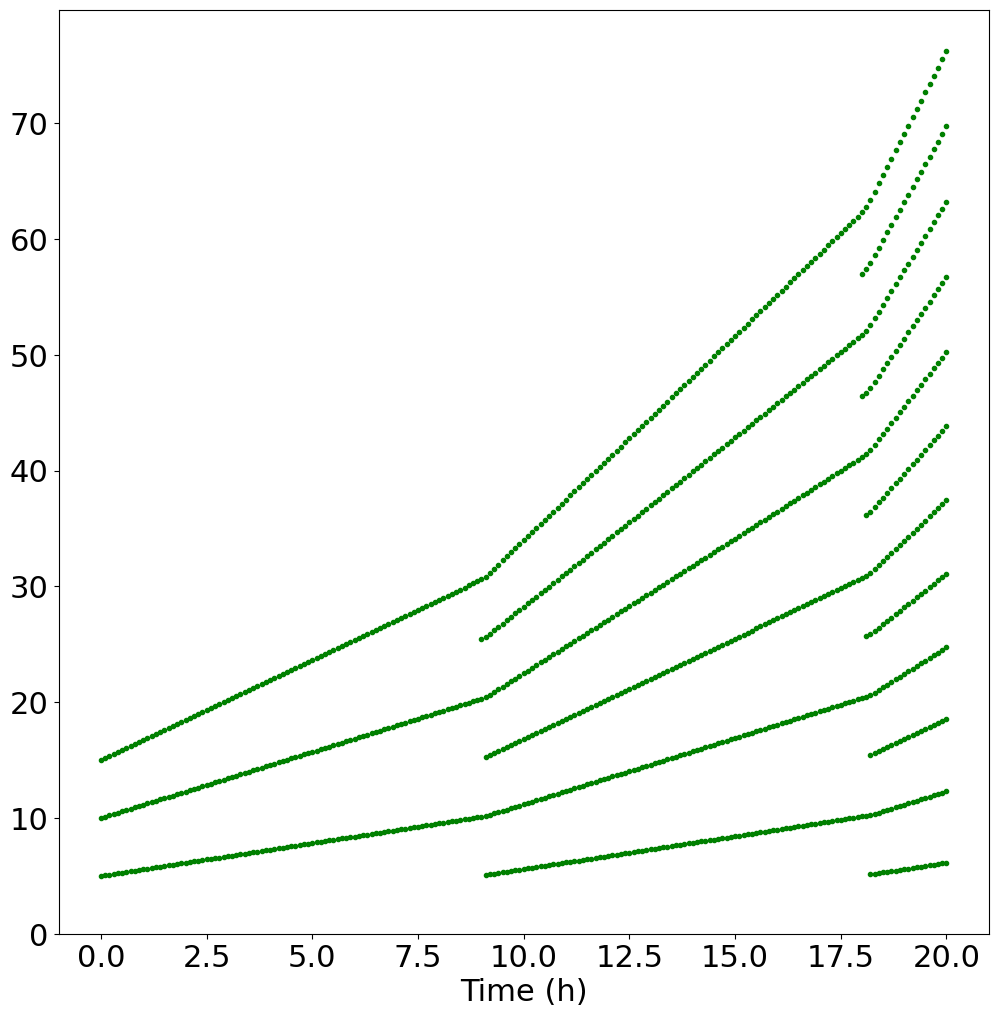

In [13]:
for t, Li in zip(ts, L):
    plt.scatter([t] * len(Li), np.cumsum(Li), marker=".", color = "green", label = "Fitted Model")

plt.xlabel("Time (h)")
plt.ylim(0, None)
mpl.rcParams['figure.figsize'] = (12, 12)
plt.savefig("img/prototype-4-model.png")